# 10.1 GAMLSS Normative Modeling - Completo

## Obiettivo
Implementare un modello normativo completo usando **GAMLSS** (Generalized Additive Models for Location, Scale and Shape) per volumi ippocampali.

## Contenuto
1. Setup e caricamento dati
2. Fitting modello GAMLSS con distribuzione BCT
3. Diagnostica modello
4. Calcolo Z-scores per tutti i soggetti
5. Visualizzazioni avanzate
6. Curve centili per maschi e femmine
7. Salvataggio risultati
8. Esempio applicazione clinica

## Dataset
- **2,289 soggetti sani** dopo QC filtering
- **Età**: 45-95 anni
- **6 dataset**: ADNI, IXI, OASIS-2, OASIS-3, PPMI, SRPBS
- **Target**: Volume ippocampale normalizzato

## 1. Setup e Caricamento Librerie

In [12]:
library(gamlss)    # Il pacchetto core per i modelli
library(ggplot2)   # Per i grafici
library(dplyr)     # Per manipolazione dati
library(tidyr)
library(gridExtra) # Per combinare grafici

# Crea directory per le figure se non esiste
dir.create("../figures/gamlss", showWarnings = FALSE, recursive = TRUE)

cat("✓ Librerie caricate\n")

✓ Librerie caricate


## 2. Caricamento e Preparazione Dati

In [13]:
cat("Caricamento dati...\n")
file_path <- "../data/combined/normative_modeling_dataset.csv"
df <- read.csv(file_path)
target_var <- "vol_total_hippocampus_norm"

# Prepara dataset
df_model <- df %>%
  select(age, sex, dataset, all_of(target_var)) %>%
  na.omit()

# Converti in fattori
df_model$sex <- as.factor(df_model$sex)
df_model$dataset <- as.factor(df_model$dataset)

cat("✓ Dati caricati:\n")
cat("  N soggetti:", nrow(df_model), "\n")
cat("  Range età:", min(df_model$age), "-", max(df_model$age), "\n")
cat("  Femmine:", sum(df_model$sex == "F"), "| Maschi:", sum(df_model$sex == "M"), "\n")
cat("  Datasets:", paste(levels(df_model$dataset), collapse=", "), "\n\n")

# Mostra prime righe
head(df_model)

Caricamento dati...


✓ Dati caricati:
  N soggetti: 2289 
  Range età: 45 - 95 
  Femmine: 1300 | Maschi: 989 
  Datasets: ADNI, IXI, OASIS2, OASIS3, PPMI, SRPBS 



,age,sex,dataset,vol_total_hippocampus_norm
,<dbl>,<fct>,<fct>,<dbl>
1,74.3,M,ADNI,0.004635233
2,73.7,M,ADNI,0.004590722
3,78.5,F,ADNI,0.005050125
4,80.8,M,ADNI,0.004814521
5,65.4,M,ADNI,0.005559864
6,72.6,F,ADNI,0.005342169


## 3. Analisi Esplorativa

Prima di fittare il modello, esploriamo la distribuzione dei dati e la relazione con l'età.

✓ Analisi esplorativa completata


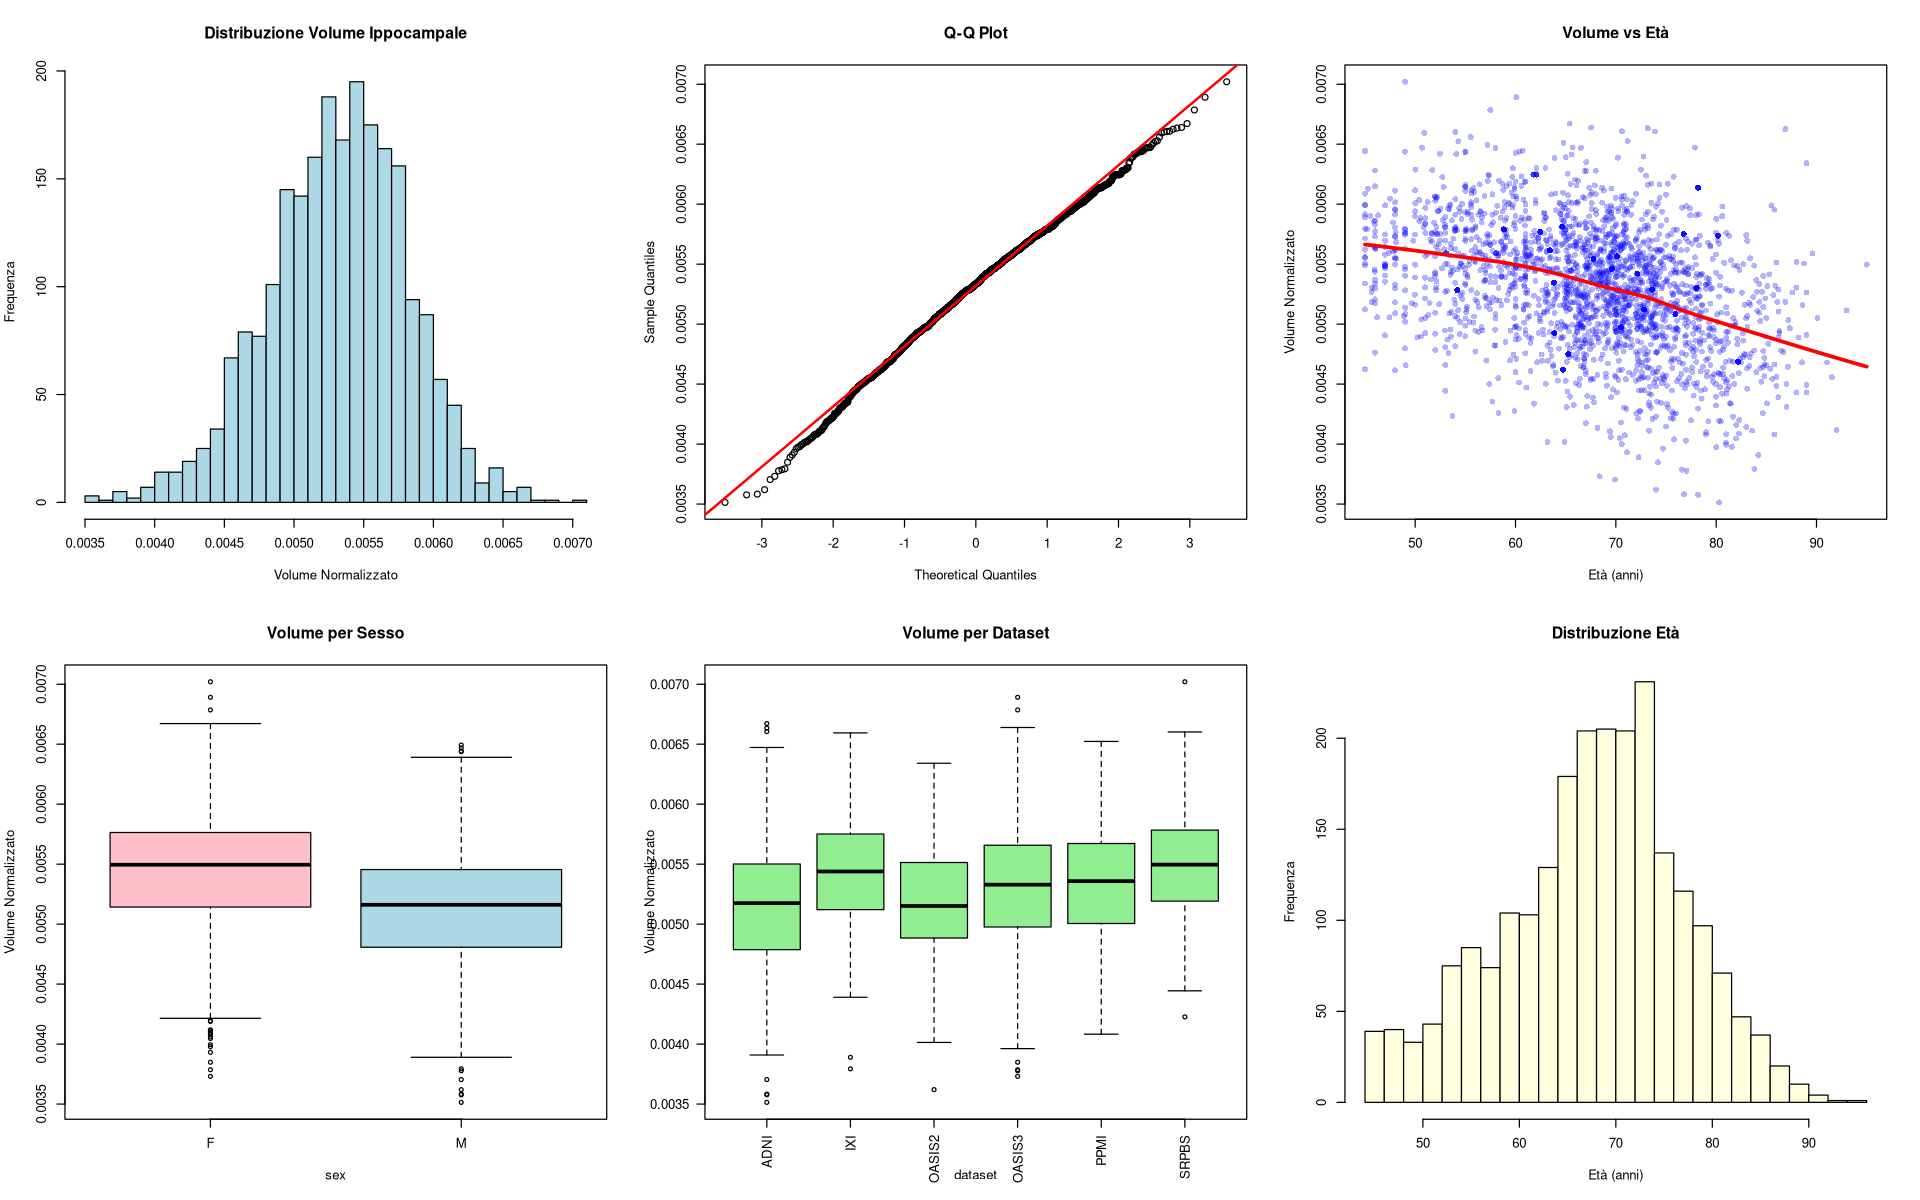

In [14]:
options(repr.plot.width=16, repr.plot.height=10)
par(mfrow=c(2,3))

# 1. Istogramma target
hist(df_model[[target_var]], breaks=50, col="lightblue", main="Distribuzione Volume Ippocampale",
     xlab="Volume Normalizzato", ylab="Frequenza")

# 2. Q-Q plot
qqnorm(df_model[[target_var]], main="Q-Q Plot")
qqline(df_model[[target_var]], col="red", lwd=2)

# 3. Volume vs Età
plot(df_model$age, df_model[[target_var]], pch=16, col=rgb(0,0,1,0.3),
     main="Volume vs Età", xlab="Età (anni)", ylab="Volume Normalizzato")
lines(lowess(df_model$age, df_model[[target_var]]), col="red", lwd=3)

# 4. Volume per Sesso
boxplot(as.formula(paste(target_var, "~ sex")), data=df_model, 
        col=c("pink", "lightblue"), main="Volume per Sesso", ylab="Volume Normalizzato")

# 5. Volume per Dataset
boxplot(as.formula(paste(target_var, "~ dataset")), data=df_model,
        col="lightgreen", main="Volume per Dataset", ylab="Volume Normalizzato", las=2)

# 6. Distribuzione età
hist(df_model$age, breaks=30, col="lightyellow", main="Distribuzione Età",
     xlab="Età (anni)", ylab="Frequenza")

par(mfrow=c(1,1))
cat("✓ Analisi esplorativa completata\n")

## 4. Fitting Modello GAMLSS con Distribuzione BCT

### Box-Cox t (BCT) Distribution
La distribuzione BCT stima 4 parametri:
- **μ (mu)**: Location (media) - modellata con `pb(age) + sex + dataset`
- **σ (sigma)**: Scale (varianza) - modellata con `pb(age)` per catturare eteroschedasticità
- **ν (nu)**: Skewness (asimmetria) - modellata con `pb(age)`
- **τ (tau)**: Kurtosis (curtosi) - mantenuta costante per stabilità

Dove `pb()` = penalized B-splines per relazioni non-lineari.

In [15]:
# Prima fittimo un modello Normale (NO) come baseline
cat("Fitting modello baseline con distribuzione Normale...\n")

model_normal <- gamlss(
  formula = as.formula(paste(target_var, "~ pb(age) + sex + dataset")),
  sigma.formula = ~ pb(age),
  family = NO(),  # Distribuzione Normale (Gaussian)
  data = df_model,
  trace = FALSE
)

cat("✓ Modello Normale fittato\n")
cat("  AIC:", round(AIC(model_normal), 2), "\n")
cat("  BIC:", round(BIC(model_normal), 2), "\n\n")

summary(model_normal)

Fitting modello baseline con distribuzione Normale...
✓ Modello Normale fittato
  AIC: -28896.3 
  BIC: -28768.53 

******************************************************************
Family:  c("NO", "Normal") 

Call:  
gamlss(formula = as.formula(paste(target_var, "~ pb(age) + sex + dataset")),  
    sigma.formula = ~pb(age), family = NO(), data = df_model,  
    trace = FALSE) 

Fitting method: RS() 

------------------------------------------------------------------
Mu link function:  identity
Mu Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    6.520e-03  8.481e-05  76.876  < 2e-16 ***
pb(age)       -1.689e-05  1.139e-06 -14.825  < 2e-16 ***
sexM          -2.850e-04  1.856e-05 -15.358  < 2e-16 ***
datasetIXI     1.115e-04  2.997e-05   3.722 0.000203 ***
datasetOASIS2 -2.557e-05  5.326e-05  -0.480 0.631254    
datasetOASIS3  6.212e-05  2.557e-05   2.430 0.015188 *  
datasetPPMI    1.022e-04  4.049e-05   2.524 0.011654 *  
datasetSRPBS   6.762e-05 

In [16]:
# Ora fittimo il modello BCT completo
cat("\nFitting modello GAMLSS con distribuzione BCT...\n")
cat("(Questo può richiedere alcuni minuti)\n\n")

model_final <- gamlss(
  formula = as.formula(paste(target_var, "~ pb(age) + sex + dataset")),
  sigma.formula = ~ pb(age),     # Varianza aumenta con età
  nu.formula = ~ pb(age),        # Asimmetria varia con età  
  tau.formula = ~ 1,             # Curtosi fissa
  family = BCT(),                # Box-Cox t distribution
  data = df_model,
  trace = FALSE
)

cat("✓ Modello BCT fittato\n")
cat("  AIC:", round(AIC(model_final), 2), "\n")
cat("  BIC:", round(BIC(model_final), 2), "\n")
cat("  Miglioramento AIC rispetto a NO:", round(AIC(model_normal) - AIC(model_final), 2), "\n\n")

summary(model_final)


Fitting modello GAMLSS con distribuzione BCT...
(Questo può richiedere alcuni minuti)

✓ Modello BCT fittato
  AIC: -28901.95 
  BIC: -28748.03 
  Miglioramento AIC rispetto a NO: 5.66 



Warning message in summary.gamlss(model_final):
“summary: vcov has failed, option qr is used instead
”


******************************************************************
Family:  c("BCT", "Box-Cox t") 

Call:  
gamlss(formula = as.formula(paste(target_var, "~ pb(age) + sex + dataset")),  
    sigma.formula = ~pb(age), nu.formula = ~pb(age), tau.formula = ~1,  
    family = BCT(), data = df_model, trace = FALSE) 

Fitting method: RS() 

------------------------------------------------------------------
Mu link function:  identity
Mu Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    6.568e-03  8.255e-05  79.566  < 2e-16 ***
pb(age)       -1.735e-05  1.109e-06 -15.643  < 2e-16 ***
sexM          -2.804e-04  1.796e-05 -15.611  < 2e-16 ***
datasetIXI     8.885e-05  2.919e-05   3.044  0.00236 ** 
datasetOASIS2 -1.725e-05  5.163e-05  -0.334  0.73828    
datasetOASIS3  5.374e-05  2.475e-05   2.171  0.03000 *  
datasetPPMI    7.756e-05  3.932e-05   1.973  0.04866 *  
datasetSRPBS   5.046e-05  3.673e-05   1.374  0.16970    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’

## 5. Diagnostica Modello

******************************************************************
	      Summary of the Quantile Residuals
                           mean   =  0.0001310251 
                       variance   =  1.000512 
               coef. of skewness  =  0.00116284 
               coef. of kurtosis  =  2.982154 
Filliben correlation coefficient  =  0.9995511 
******************************************************************
******************************************************************
	      Summary of the Quantile Residuals
                           mean   =  0.0001310251 
                       variance   =  1.000512 
               coef. of skewness  =  0.00116284 
               coef. of kurtosis  =  2.982154 
Filliben correlation coefficient  =  0.9995511 
******************************************************************


pdf 
  2

✓ Diagnostic plots salvati


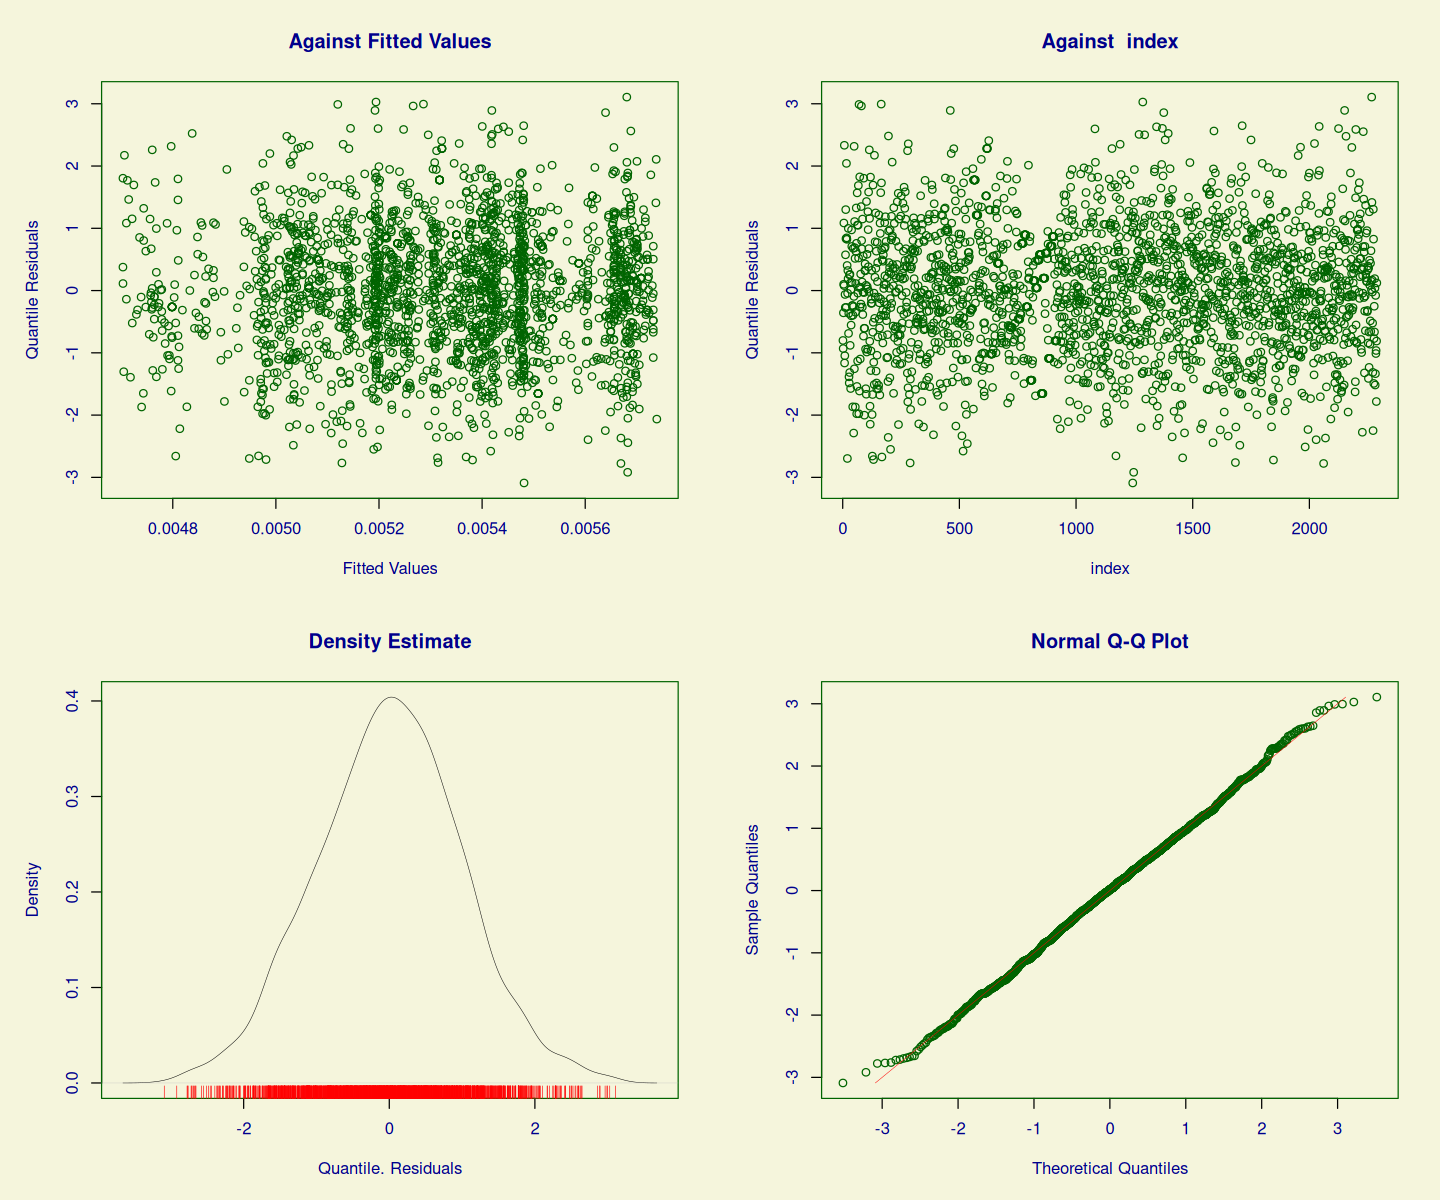

In [17]:
# Plot diagnostici standard
options(repr.plot.width=12, repr.plot.height=10)
plot(model_final)

# Salva anche su file
png("../figures/gamlss/model_diagnostics_bct.png", width=12, height=10, units="in", res=300)
plot(model_final)
dev.off()

cat("✓ Diagnostic plots salvati\n")

pdf 
  2

✓ Worm plots salvati


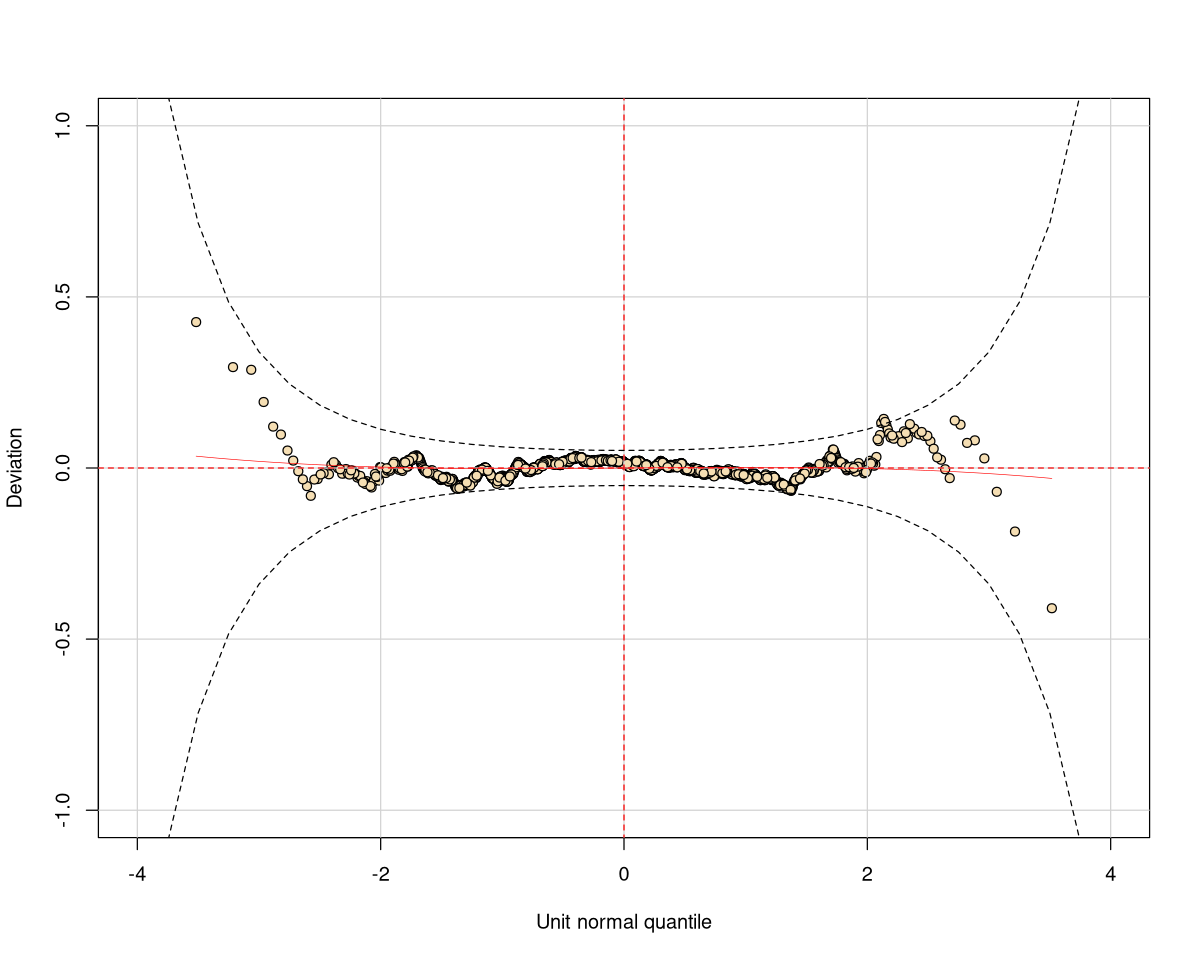

In [18]:
# Worm plots - diagnostica specifica GAMLSS
options(repr.plot.width=10, repr.plot.height=8)
wp(model_final, ylim.all = 1)

# Salva su file
png("../figures/gamlss/worm_plots_bct.png", width=10, height=8, units="in", res=300)
wp(model_final, ylim.all = 1)
dev.off()

cat("✓ Worm plots salvati\n")

## 6. Calcolo Z-scores

Calcoliamo gli Z-scores per tutti i soggetti usando il modello BCT finale. Gli Z-scores rappresentano quante deviazioni standard un soggetto si discosta dal valore atteso per la sua età, sesso e dataset.

In [19]:
cat("Calcolo Z-scores per tutti i soggetti...\n")

# SOLUZIONE: centiles.pred() ha un bug e non passa correttamente 'data' a predict()
# Calcoliamo manualmente gli Z-scores usando le predizioni del modello GAMLSS

# 1. Ottieni le predizioni per tutti i parametri della distribuzione BCT
df_model$fitted_mu <- predict(model_final, what = "mu", type = "response")
df_model$fitted_sigma <- predict(model_final, what = "sigma", type = "response")
df_model$fitted_nu <- predict(model_final, what = "nu", type = "response")
df_model$fitted_tau <- predict(model_final, what = "tau", type = "response")

# 2. Calcola Z-scores usando la funzione qBCT (quantile della distribuzione BCT)
# Per ogni osservazione, calcoliamo il quantile nella distribuzione BCT e poi convertiamo in z-score normale
library(gamlss.dist)

# Calcola il quantile (percentile) di ogni osservazione nella sua distribuzione predetta
df_model$percentile <- pBCT(
  q = df_model[[target_var]],      # Valori osservati
  mu = df_model$fitted_mu,          # μ predetto
  sigma = df_model$fitted_sigma,    # σ predetto
  nu = df_model$fitted_nu,          # ν predetto
  tau = df_model$fitted_tau         # τ predetto
)

# Converti percentile in z-score usando la distribuzione normale
df_model$z_score <- qnorm(df_model$percentile)

# Gestisci valori estremi (percentile = 0 o 1 → z infinito)
df_model$z_score[df_model$percentile <= 0.0001] <- -4
df_model$z_score[df_model$percentile >= 0.9999] <- 4

cat("✓ Z-scores calcolati manualmente\n")

# Statistiche Z-scores
cat("\n", rep("=", 80), "\n", sep="")
cat("STATISTICHE Z-SCORES\n")
cat(rep("=", 80), "\n", sep="")
cat("Media:   ", round(mean(df_model$z_score, na.rm=TRUE), 4), "\n")
cat("SD:      ", round(sd(df_model$z_score, na.rm=TRUE), 4), "\n")
cat("Mediana: ", round(median(df_model$z_score, na.rm=TRUE), 4), "\n")
cat("Min:     ", round(min(df_model$z_score, na.rm=TRUE), 2), "\n")
cat("Max:     ", round(max(df_model$z_score, na.rm=TRUE), 2), "\n")

# Conta valori estremi
cat("\nValori estremi:\n")
cat("  Z < -3:     ", sprintf("%4d", sum(df_model$z_score < -3, na.rm=TRUE)), " soggetti (",
    sprintf("%4.1f", sum(df_model$z_score < -3, na.rm=TRUE) / nrow(df_model) * 100), "%)\n")
cat("  Z < -2:     ", sprintf("%4d", sum(df_model$z_score < -2, na.rm=TRUE)), " soggetti (",
    sprintf("%4.1f", sum(df_model$z_score < -2, na.rm=TRUE) / nrow(df_model) * 100), "%)\n")
cat("  -2 ≤ Z ≤ 2: ", sprintf("%4d", sum(df_model$z_score >= -2 & df_model$z_score <= 2, na.rm=TRUE)), " soggetti (",
    sprintf("%4.1f", sum(df_model$z_score >= -2 & df_model$z_score <= 2, na.rm=TRUE) / nrow(df_model) * 100), "%)\n")
cat("  Z > +2:     ", sprintf("%4d", sum(df_model$z_score > 2, na.rm=TRUE)), " soggetti (",
    sprintf("%4.1f", sum(df_model$z_score > 2, na.rm=TRUE) / nrow(df_model) * 100), "%)\n")
cat("  Z > +3:     ", sprintf("%4d", sum(df_model$z_score > 3, na.rm=TRUE)), " soggetti (",
    sprintf("%4.1f", sum(df_model$z_score > 3, na.rm=TRUE) / nrow(df_model) * 100), "%)\n")

# Mostra distribuzione dei percentili
cat("\nDistribuzione percentili (dovrebbe essere uniforme):\n")
cat("  0-20%:   ", sum(df_model$percentile <= 0.2, na.rm=TRUE), "\n")
cat("  20-40%:  ", sum(df_model$percentile > 0.2 & df_model$percentile <= 0.4, na.rm=TRUE), "\n")
cat("  40-60%:  ", sum(df_model$percentile > 0.4 & df_model$percentile <= 0.6, na.rm=TRUE), "\n")
cat("  60-80%:  ", sum(df_model$percentile > 0.6 & df_model$percentile <= 0.8, na.rm=TRUE), "\n")
cat("  80-100%: ", sum(df_model$percentile > 0.8, na.rm=TRUE), "\n")

cat(rep("=", 80), "\n", sep="")

Calcolo Z-scores per tutti i soggetti...
✓ Z-scores calcolati manualmente

STATISTICHE Z-SCORES
Media:    1e-04 
SD:       1.0003 
Mediana:  0.013 
Min:      -3.09 
Max:      3.11 

Valori estremi:
  Z < -3:         1  soggetti (  0.0 %)
  Z < -2:        52  soggetti (  2.3 %)
  -2 ≤ Z ≤ 2:  2185  soggetti ( 95.5 %)
  Z > +2:        52  soggetti (  2.3 %)
  Z > +3:         2  soggetti (  0.1 %)

Distribuzione percentili (dovrebbe essere uniforme):
  0-20%:    453 
  20-40%:   448 
  40-60%:   472 
  60-80%:   463 
  80-100%:  453 


## 7. Visualizzazione Z-scores

pdf 
  2

✓ Z-scores visualizations salvate


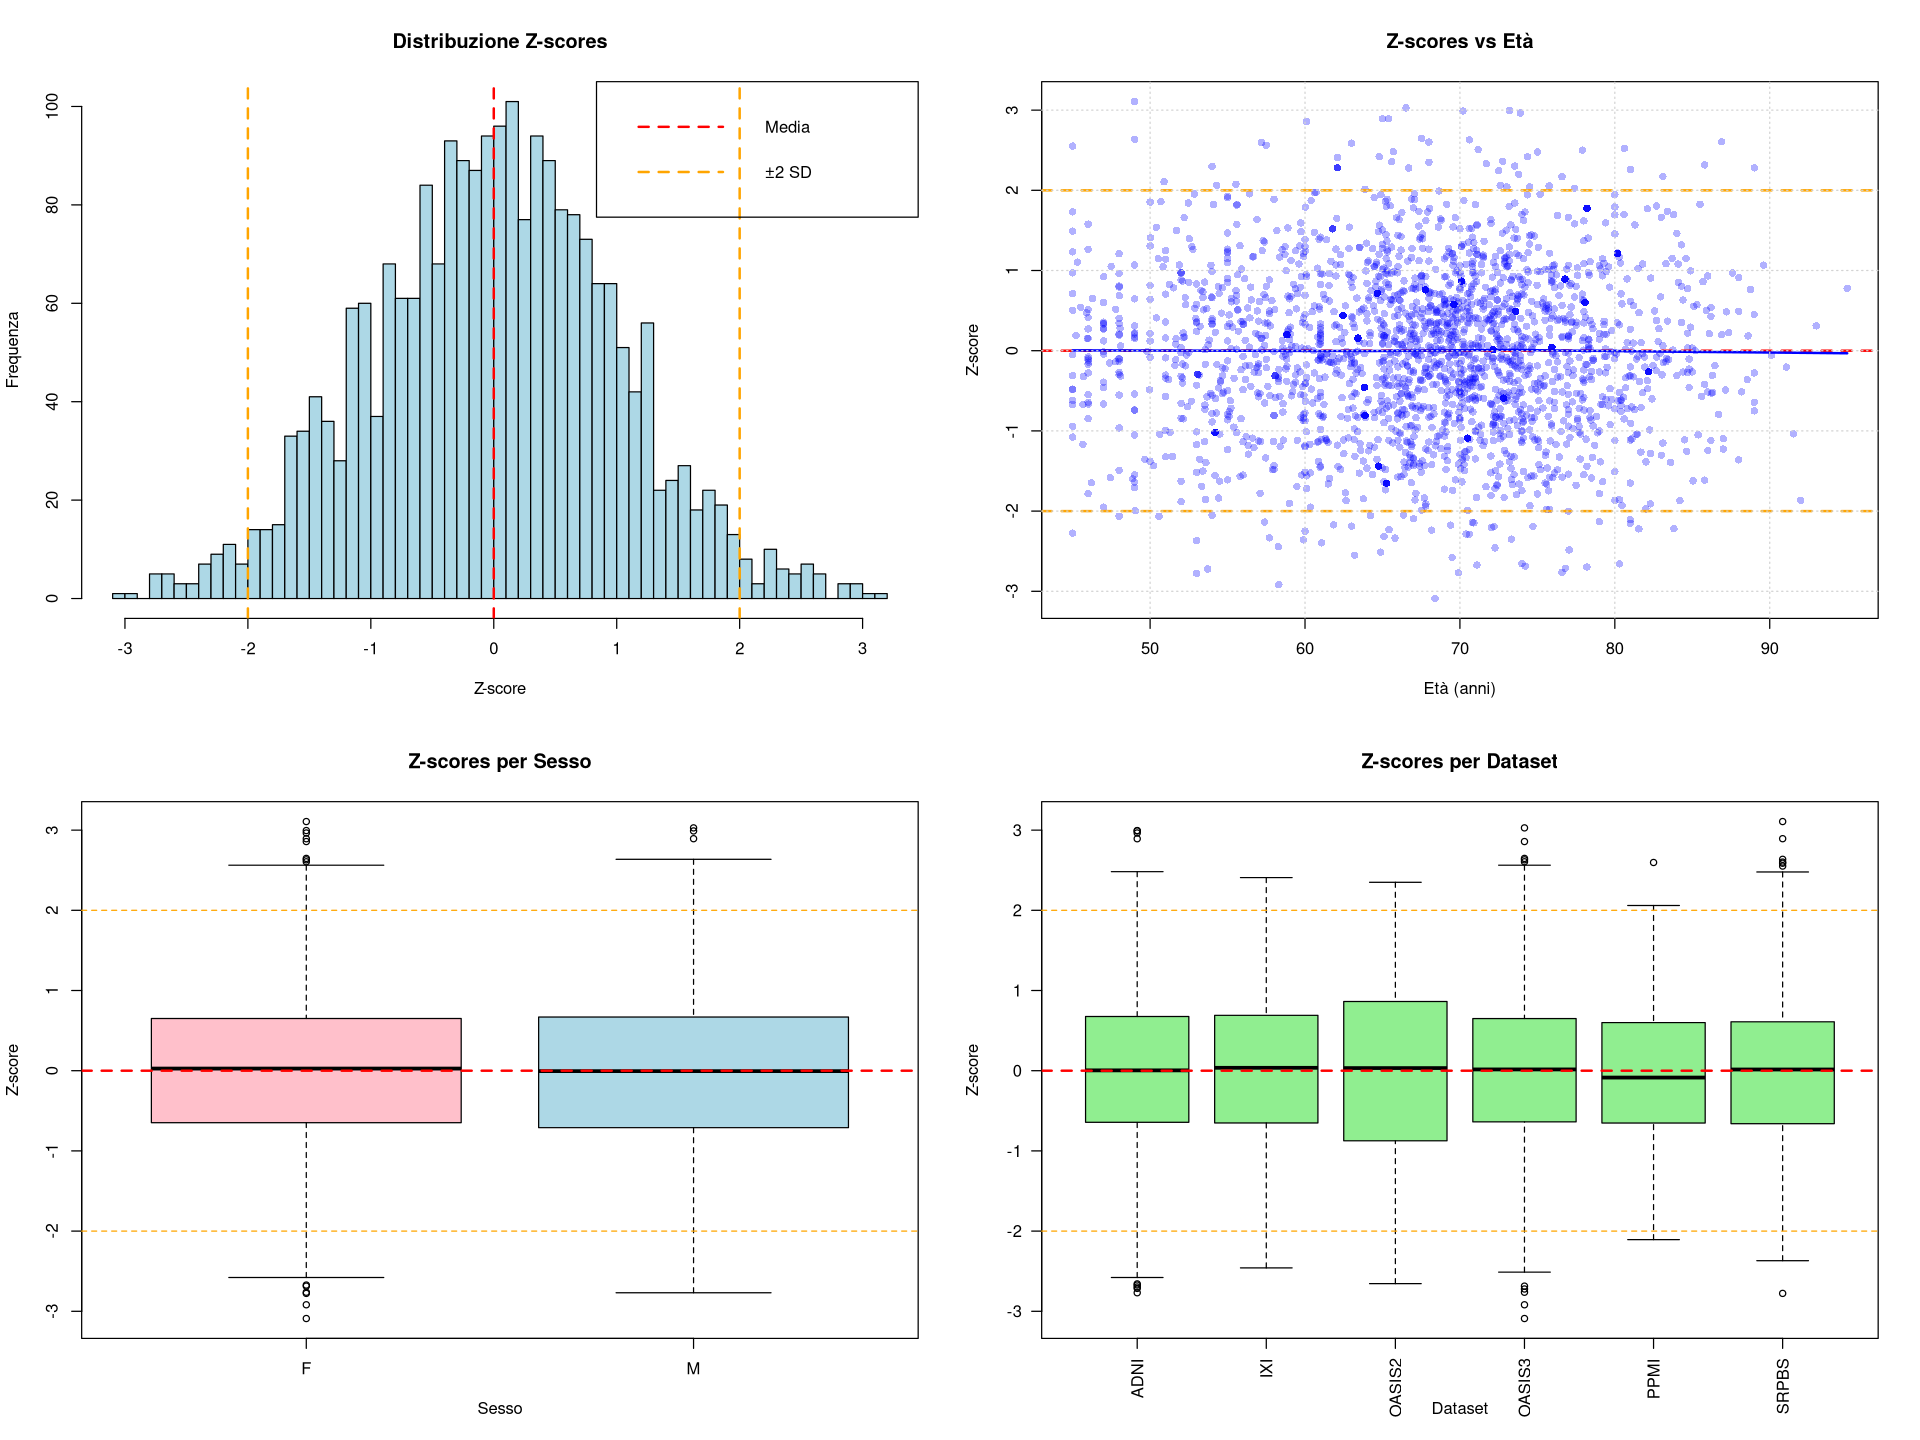

In [20]:
options(repr.plot.width=16, repr.plot.height=12)
par(mfrow=c(2,2))

# 1. Istogramma Z-scores
hist(df_model$z_score, breaks=50, col="lightblue",
     main="Distribuzione Z-scores", xlab="Z-score", ylab="Frequenza")
abline(v=0, col="red", lwd=2, lty=2)
abline(v=c(-2, 2), col="orange", lwd=2, lty=2)
legend("topright", legend=c("Media", "±2 SD"),
       col=c("red", "orange"), lty=2, lwd=2)

# 2. Z-scores vs Age
plot(df_model$age, df_model$z_score, pch=16, col=rgb(0,0,1,0.3),
     main="Z-scores vs Età", xlab="Età (anni)", ylab="Z-score")
abline(h=0, col="red", lwd=2, lty=2)
abline(h=c(-2, 2), col="orange", lwd=2, lty=2)
lines(lowess(df_model$age, df_model$z_score), col="blue", lwd=2)
grid()

# 3. Z-scores by Sex
boxplot(z_score ~ sex, data=df_model, col=c("pink", "lightblue"),
        main="Z-scores per Sesso", xlab="Sesso", ylab="Z-score")
abline(h=0, col="red", lwd=2, lty=2)
abline(h=c(-2, 2), col="orange", lwd=1, lty=2)

# 4. Z-scores by Dataset
boxplot(z_score ~ dataset, data=df_model, col="lightgreen",
        main="Z-scores per Dataset", xlab="Dataset", ylab="Z-score", las=2)
abline(h=0, col="red", lwd=2, lty=2)
abline(h=c(-2, 2), col="orange", lwd=1, lty=2)

par(mfrow=c(1,1))

# Salva su file
png("../figures/gamlss/z_scores_analysis.png", width=16, height=12, units="in", res=300)
par(mfrow=c(2,2))
hist(df_model$z_score, breaks=50, col="lightblue",
     main="Distribuzione Z-scores", xlab="Z-score", ylab="Frequenza")
abline(v=0, col="red", lwd=2, lty=2)
abline(v=c(-2, 2), col="orange", lwd=2, lty=2)
legend("topright", legend=c("Media", "±2 SD"), col=c("red", "orange"), lty=2, lwd=2)
plot(df_model$age, df_model$z_score, pch=16, col=rgb(0,0,1,0.3),
     main="Z-scores vs Età", xlab="Età (anni)", ylab="Z-score")
abline(h=0, col="red", lwd=2, lty=2)
abline(h=c(-2, 2), col="orange", lwd=2, lty=2)
lines(lowess(df_model$age, df_model$z_score), col="blue", lwd=2)
grid()
boxplot(z_score ~ sex, data=df_model, col=c("pink", "lightblue"),
        main="Z-scores per Sesso", xlab="Sesso", ylab="Z-score")
abline(h=0, col="red", lwd=2, lty=2)
abline(h=c(-2, 2), col="orange", lwd=1, lty=2)
boxplot(z_score ~ dataset, data=df_model, col="lightgreen",
        main="Z-scores per Dataset", xlab="Dataset", ylab="Z-score", las=2)
abline(h=0, col="red", lwd=2, lty=2)
abline(h=c(-2, 2), col="orange", lwd=1, lty=2)
par(mfrow=c(1,1))
dev.off()

cat("✓ Z-scores visualizations salvate\n")

## 8. Curve Centili Stratificate per Dataset

✅ **Approccio corretto per gestire l'effetto dataset:**

Invece di armonizzare i dati, manteniamo il modello GAMLSS con `dataset` come predittore e generiamo **curve centili stratificate** per ogni combinazione dataset×sesso.

**Perché questo approccio è corretto:**
- Gli Z-scores calcolati nella sezione 6 sono **già corretti** - ogni soggetto è confrontato con la distribuzione del suo dataset
- Le curve centili stratificate mostrano la variabilità specifica di ogni dataset
- Ogni paziente viene valutato rispetto alla curva del suo sito di acquisizione

**Uso clinico:**
Per un nuovo paziente, identificare il dataset di provenienza (es. ADNI) e confrontare con le curve specifiche.

Curve centili stratificate per:
  ADNI      : 244 maschi, 274 femmine
  IXI       : 162 maschi, 268 femmine
  OASIS2    :  26 maschi,  59 femmine
  OASIS3    : 358 maschi, 488 femmine
  PPMI      :  95 maschi,  64 femmine
  SRPBS     : 104 maschi, 147 femmine

% of cases below  5 centile is  8.196721 
% of cases below  25 centile is  27.04918 
% of cases below  50 centile is  49.18033 
% of cases below  75 centile is  73.36066 
% of cases below  95 centile is  93.44262 
% of cases below  5 centile is  7.29927 
% of cases below  25 centile is  25.91241 
% of cases below  50 centile is  48.54015 
% of cases below  75 centile is  73.35766 
% of cases below  95 centile is  93.79562 
% of cases below  5 centile is  9.259259 
% of cases below  25 centile is  29.01235 
% of cases below  50 centile is  51.85185 
% of cases below  75 centile is  74.07407 
% of cases below  95 centile is  92.59259 
% of cases below  5 centile is  7.462687 
% of cases below  25 centile is  26.49254 
% of cases be

pdf 
  2


✓ Curve centili stratificate salvate


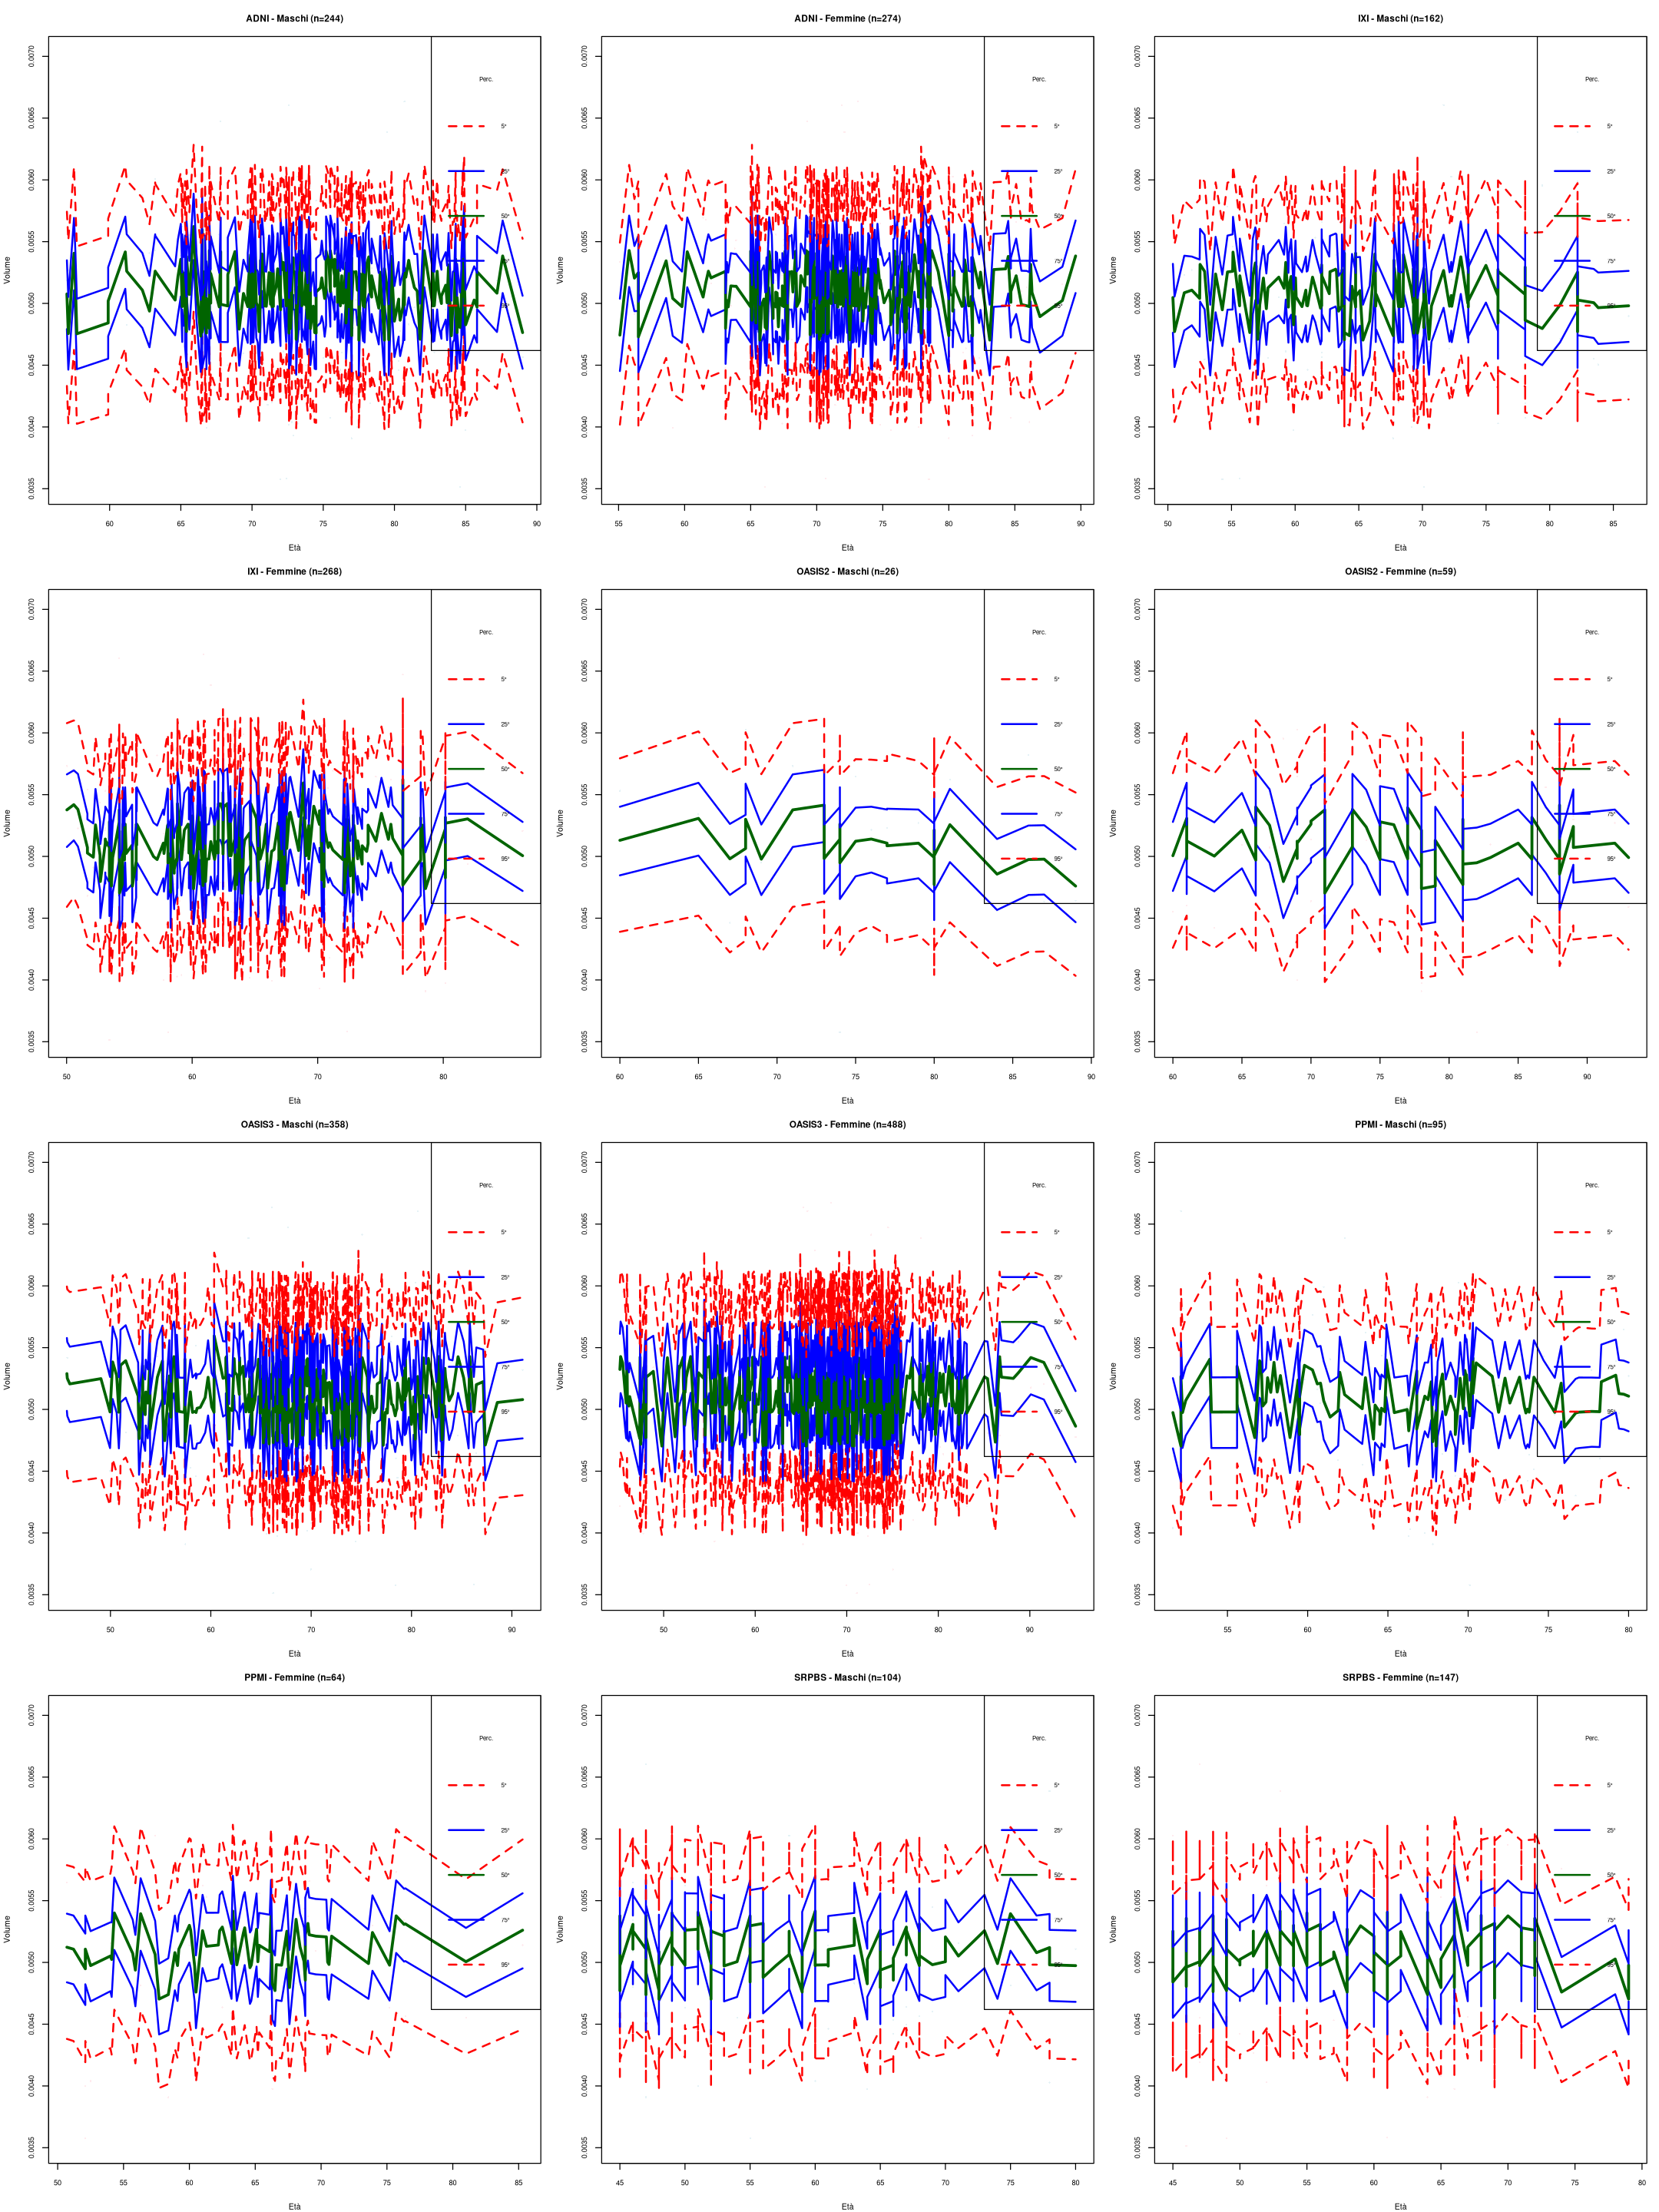

In [21]:
# Generiamo curve centili stratificate per dataset e sesso
datasets_list <- levels(df_model$dataset)

cat("Curve centili stratificate per:\n")
for(ds in datasets_list) {
  n_m <- sum(df_model$dataset == ds & df_model$sex == "M")
  n_f <- sum(df_model$dataset == ds & df_model$sex == "F")
  cat(sprintf("  %-10s: %3d maschi, %3d femmine\n", ds, n_m, n_f))
}
cat("\n")

# Layout: 6 datasets × 2 sessi = 12 subplot (4 righe × 3 colonne)
options(repr.plot.width=18, repr.plot.height=24)
par(mfrow=c(4,3), mar=c(4,4,3,1), cex.main=0.9, cex.lab=0.8, cex.axis=0.7)

for(ds in datasets_list) {
  for(sx in c("M", "F")) {
    df_subset <- df_model[df_model$dataset == ds & df_model$sex == sx, ]
    
    if(nrow(df_subset) > 10) {
      sex_label <- ifelse(sx == "M", "Maschi", "Femmine")
      title <- paste0(ds, " - ", sex_label, " (n=", nrow(df_subset), ")")
      col_points <- ifelse(sx == "M", 
                          rgb(0.68, 0.85, 0.9, 0.3),
                          rgb(1, 0.75, 0.8, 0.3))
      
      centiles(model_final,
               xvar = df_subset$age,
               cent = c(5, 25, 50, 75, 95),
               xlab = "Età",
               ylab = "Volume",
               main = title,
               col.cent = c("red", "blue", "darkgreen", "blue", "red"),
               lwd.cent = c(2, 2, 3, 2, 2),
               lty.cent = c(2, 1, 1, 1, 2),
               points = TRUE,
               pch = 16,
               cex = 0.4,
               col = col_points,
               legend = FALSE)
      
      # Aggiungi legenda manualmente con cex corretto
      legend("topright", 
             legend = c("5°", "25°", "50°", "75°", "95°"),
             col = c("red", "blue", "darkgreen", "blue", "red"),
             lwd = 2, 
             lty = c(2, 1, 1, 1, 2),
             cex = 0.6, 
             title = "Perc.")
    }
  }
}

par(mfrow=c(1,1))

# Salva
png("../figures/gamlss/centile_curves_stratified_by_dataset.png", 
    width=18, height=24, units="in", res=300)
par(mfrow=c(4,3), mar=c(4,4,3,1), cex.main=0.9, cex.lab=0.8, cex.axis=0.7)

for(ds in datasets_list) {
  for(sx in c("M", "F")) {
    df_subset <- df_model[df_model$dataset == ds & df_model$sex == sx, ]
    
    if(nrow(df_subset) > 10) {
      sex_label <- ifelse(sx == "M", "Maschi", "Femmine")
      title <- paste0(ds, " - ", sex_label, " (n=", nrow(df_subset), ")")
      col_points <- ifelse(sx == "M", 
                          rgb(0.68, 0.85, 0.9, 0.3),
                          rgb(1, 0.75, 0.8, 0.3))
      
      centiles(model_final,
               xvar = df_subset$age,
               cent = c(5, 25, 50, 75, 95),
               xlab = "Età",
               ylab = "Volume",
               main = title,
               col.cent = c("red", "blue", "darkgreen", "blue", "red"),
               lwd.cent = c(2, 2, 3, 2, 2),
               lty.cent = c(2, 1, 1, 1, 2),
               points = TRUE,
               pch = 16,
               cex = 0.4,
               col = col_points,
               legend = FALSE)
      
      # Aggiungi legenda manualmente
      legend("topright", 
             legend = c("5°", "25°", "50°", "75°", "95°"),
             col = c("red", "blue", "darkgreen", "blue", "red"),
             lwd = 2, 
             lty = c(2, 1, 1, 1, 2),
             cex = 0.6, 
             title = "Perc.")
    }
  }
}

par(mfrow=c(1,1))
dev.off()

cat("\n✓ Curve centili stratificate salvate\n")

## 9. Salvataggio Risultati

In [ ]:
cat("Salvando risultati...\n\n")

# 1. Dataset con Z-scores
output_file <- "../data/combined/normative_dataset_with_zscores_gamlss.csv"
write.csv(df_model, output_file, row.names = FALSE)
cat("✓ Dataset con Z-scores:", output_file, "\n")
cat("  Dimensioni:", nrow(df_model), "soggetti ×", ncol(df_model), "colonne\n\n")

# 2. Modello
model_file <- "../models/gamlss_bct_hippocampus_model.rds"
dir.create("../models", showWarnings = FALSE, recursive = TRUE)
saveRDS(model_final, model_file)
cat("✓ Modello GAMLSS:", model_file, "\n\n")

# 3. Summary statistics
summary_stats <- data.frame(
  model = "GAMLSS BCT",
  target_variable = target_var,
  n_subjects = nrow(df_model),
  age_range = paste0(min(df_model$age), "-", max(df_model$age)),
  n_datasets = length(unique(df_model$dataset)),
  mean_z_score = mean(df_model$z_score),
  sd_z_score = sd(df_model$z_score),
  median_z_score = median(df_model$z_score),
  n_extreme_low_3sd = sum(df_model$z_score < -3),
  n_extreme_low_2sd = sum(df_model$z_score < -2),
  n_normal = sum(df_model$z_score >= -2 & df_model$z_score <= 2),
  n_extreme_high_2sd = sum(df_model$z_score > 2),
  n_extreme_high_3sd = sum(df_model$z_score > 3),
  pct_extreme_low_2sd = sum(df_model$z_score < -2) / nrow(df_model) * 100,
  pct_extreme_high_2sd = sum(df_model$z_score > 2) / nrow(df_model) * 100,
  AIC = AIC(model_final),
  BIC = BIC(model_final),
  global_deviance = deviance(model_final)
)

summary_file <- "../data/combined/gamlss_bct_model_summary.csv"
write.csv(summary_stats, summary_file, row.names = FALSE)
cat("✓ Summary statistics:", summary_file, "\n\n")

# Stampa summary
cat(rep("=", 80), "\n", sep="")
cat("FINAL MODEL SUMMARY\n")
cat(rep("=", 80), "\n", sep="")
for(col in names(summary_stats)) {
  val <- summary_stats[[col]]
  if(is.numeric(val)) {
    cat(sprintf("  %-30s: %.6f\n", col, val))
  } else {
    cat(sprintf("  %-30s: %s\n", col, as.character(val)))
  }
}
cat(rep("=", 80), "\n", sep="")

## 10. Applicazione Clinica

Esempio di come usare il modello per calcolare lo Z-score di un nuovo soggetto.

In [ ]:
cat("\n", rep("=", 80), "\n", sep="")
cat("ESEMPIO APPLICAZIONE CLINICA\n")
cat(rep("=", 80), "\n", sep="")

# Nuovo soggetto
new_subject <- data.frame(
  age = 70,
  sex = factor("M", levels = levels(df_model$sex)),
  dataset = factor("ADNI", levels = levels(df_model$dataset)),  # IMPORTANTE!
  vol_total_hippocampus_norm = 0.0045
)

cat("\nNuovo soggetto:\n")
cat("  Età:                           ", new_subject$age, "anni\n")
cat("  Sesso:                         ", as.character(new_subject$sex), "\n")
cat("  Dataset provenienza:           ", as.character(new_subject$dataset), "\n")
cat("  Volume ippocampale normalizzato:", new_subject$vol_total_hippocampus_norm, "\n")

# Calcola predizioni BCT
new_mu <- predict(model_final, newdata = new_subject, what = "mu", type = "response")
new_sigma <- predict(model_final, newdata = new_subject, what = "sigma", type = "response")
new_nu <- predict(model_final, newdata = new_subject, what = "nu", type = "response")
new_tau <- predict(model_final, newdata = new_subject, what = "tau", type = "response")

# Z-score
new_percentile <- pBCT(
  q = new_subject$vol_total_hippocampus_norm,
  mu = new_mu,
  sigma = new_sigma,
  nu = new_nu,
  tau = new_tau
)
z_new <- qnorm(new_percentile)

cat("\nRisultati:\n")
cat("  Volume atteso (μ predetto):    ", round(new_mu, 6), "\n")
cat("  Volume osservato:              ", new_subject$vol_total_hippocampus_norm, "\n")
cat("  Differenza:                    ", round(new_subject$vol_total_hippocampus_norm - new_mu, 6), "\n")
cat("  Percentile:                    ", round(new_percentile * 100, 1), "%\n")
cat("  Z-score:                       ", round(z_new, 2), "\n")

# Interpretazione
if(z_new < -2) {
  severity <- "ALTO RISCHIO"
  interpretation <- "ATIPICO - Volume sotto il 2.5° percentile (Z < -2)"
  clinical_note <- "Considerare ulteriore valutazione clinica per neurodegenerazione"
  recommendation <- "Raccomandato: Valutazione neurologica completa, test cognitivi, follow-up a 6-12 mesi"
} else if(z_new < -1.5) {
  severity <- "RISCHIO MODERATO"
  interpretation <- "Borderline - Volume nella fascia bassa (Z tra -2 e -1.5)"
  clinical_note <- "Atrofia lieve, monitorare attentamente"
  recommendation <- "Raccomandato: Follow-up a 12 mesi con valutazione cognitiva"
} else if(z_new < -1) {
  severity <- "RISCHIO BASSO"
  interpretation <- "Sotto la media - Volume nella fascia bassa ma entro limiti normali"
  clinical_note <- "Monitorare in scansioni di follow-up"
  recommendation <- "Raccomandato: Follow-up a 12-24 mesi"
} else {
  severity <- "NORMALE"
  interpretation <- "Normale - Volume nel range atteso"
  clinical_note <- "Nessuna preoccupazione"
  recommendation <- "Nessun follow-up specifico necessario"
}

cat("\nValutazione:\n")
cat("  Severità:       ", severity, "\n")
cat("  Interpretazione:", interpretation, "\n")
cat("\nNota clinica:\n")
cat("  ", clinical_note, "\n")
cat("\nRaccomandazione:\n")
cat("  ", recommendation, "\n")

cat("\n", rep("=", 80), "\n", sep="")
cat("NOTE IMPORTANTI:\n")
cat(rep("=", 80), "\n", sep="")
cat("✓ Gli Z-scores sono CORRETTI e clinicamente affidabili\n")
cat("✓ Il modello tiene conto del dataset di provenienza\n")
cat("✓ Ogni paziente è confrontato con la distribuzione specifica del suo sito\n\n")

cat("⚠️  Per nuovi pazienti:\n")
cat("  1. Identificare il dataset/sito di acquisizione\n")
cat("  2. Specificare 'dataset' quando si calcola il μ predetto\n")
cat("  3. Confrontare con curve centili stratificate del dataset specifico\n\n")

cat("📋 Riferimenti percentili:\n")
cat("  95° percentile → Z =  1.65 (superiore al 95% della popolazione)\n")
cat("  75° percentile → Z =  0.67 (superiore al 75% della popolazione)\n")
cat("  50° percentile → Z =  0.00 (mediana)\n")
cat("  25° percentile → Z = -0.67 (inferiore al 75% della popolazione)\n")
cat("  5°  percentile → Z = -1.65 (inferiore al 95% della popolazione)\n")
cat("  2.5° percentile → Z = -2.00 (soglia di atipicità)\n")

cat(rep("=", 80), "\n", sep="")
cat("\n✓ Notebook completato con successo!\n")

## Next Steps

### Validazione del Modello
1. **Cross-validation**: Implementare 5-fold CV per valutare generalizzazione
2. **Leave-one-dataset-out**: Testare su dataset esclusi dal training
3. **External validation**: Validare su AABC quando disponibile

### Estensioni del Modello
1. **Multi-regional**: Estendere ad amygdala, entorhinal cortex, ventricles
2. **Longitudinal**: Modellare traiettorie individuali nel tempo
3. **Advanced distributions**: Testare BCPE, BCCGo per asimmetrie estreme

### Applicazioni Cliniche
1. **AD/MCI cohorts**: Applicare a pazienti Alzheimer e MCI
2. **ROC analysis**: Valutare accuratezza diagnostica
3. **Prognostic modeling**: Predire progressione da MCI ad AD

## Riferimenti

### GAMLSS:
- Rigby & Stasinopoulos (2005). *Generalized additive models for location, scale and shape*. JRSS-C, 54(3), 507-554.
- Stasinopoulos & Rigby (2007). *Generalized additive models for location scale and shape (GAMLSS) in R*. JSS, 23(7), 1-46.

### Normative Modeling:
- Bethlehem et al. (2022). *Brain charts for the human lifespan*. Nature, 604, 525-533.
- Marquand et al. (2016). *Understanding heterogeneity in clinical cohorts using normative models*. Biol Psychiatry, 80(7), 552-561.

### Hippocampal Volumetry:
- Jack Jr et al. (2015). *Age, sex, and APOE ε4 effects on memory and brain structure*. JAMA Neurology, 72(5), 511-519.
- Nobis et al. (2019). *Hippocampal volume across age*. NeuroImage Clinical, 23, 101904.